<a href="https://colab.research.google.com/github/srushtidayanand/MAML_Meta-learning/blob/main/GAN_MAML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch  # Core PyTorch library
import torch.nn as nn  # Neural network modules (layers, loss functions)
import torch.optim as optim  # Optimizers like SGD, Adam
import torchvision.transforms as transforms  # Image preprocessing tools
from torchvision.datasets import MNIST  # MNIST dataset (handwritten digits)
from torch.utils.data import DataLoader, Subset  # For batching and dataset splitting
import numpy as npa  # NumPy for array operations (alias `npa`)
import matplotlib.pyplot as plt  # Plotting library
from tqdm import tqdm  # Progress bar for loops


In [ ]:
# Set device to GPU if available, else fallback to CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")  # Print the selected device


Using device: cuda


In [ ]:
# CNN-based Generator for GAN
# This model takes a latent noise vector (e.g., 100-dim) and generates a 28x28 image (like MNIST)
class CNNGenerator(nn.Module):
    def __init__(self, latent_dim=100):  # latent_dim = size of input noise vector z
        super(CNNGenerator, self).__init__()

        # ===== Fully Connected Layer =====
        # Input: (batch_size, 100)
        # Output: (batch_size, 128 * 7 * 7) = (batch_size, 6272)
        # Why 128*7*7? => We'll reshape it to (128 channels, 7x7 feature map) before deconvolution
        self.fc = nn.Sequential(
            nn.Linear(latent_dim, 128 * 7 * 7),  # 100 → 6272
            nn.ReLU()  # Apply ReLU non-linearity
        )

        # ===== Deconvolution (Upsampling) Layers =====
        # After reshape: input becomes (batch_size, 128, 7, 7)

        self.deconv = nn.Sequential(
            # ConvTranspose2d:
            # Input:  (batch_size, 128, 7, 7)
            # Output: (batch_size, 64, 14, 14)
            # Kernel size = 4, stride = 2, padding = 1 → Upsamples spatial size: 7x7 → 14x14
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),

            # BatchNorm: normalize 64 channels independently
            nn.BatchNorm2d(64),

            # ReLU activation
            nn.ReLU(),

            # ConvTranspose2d:
            # Input:  (batch_size, 64, 14, 14)
            # Output: (batch_size, 1, 28, 28)
            # Same kernel, stride, padding as before: 14x14 → 28x28
            nn.ConvTranspose2d(64, 1, kernel_size=4, stride=2, padding=1),

            # Tanh activation:
            # Final image pixel values will be scaled to range [-1, 1], matching normalized MNIST format
            nn.Tanh()
        )

    def forward(self, z):  # z: (batch_size, 100)
        x = self.fc(z)  # Output: (batch_size, 6272)
        x = x.view(z.size(0), 128, 7, 7)  # Reshape to 4D: (batch_size, 128 channels, 7, 7)
        img = self.deconv(x)  # Output: (batch_size, 1, 28, 28)
        return img  # Final generated image


In [ ]:
# CNN-based Discriminator for GAN
# Goal: Take a 28x28 grayscale image and output a probability that it's "real"
# In MAML, this can be adapted per task to quickly judge new image distributions

class CNNDiscriminator(nn.Module):
    def __init__(self):
        super(CNNDiscriminator, self).__init__()

        # === Feature extractor block ===
        self.features = nn.Sequential(

            # First Conv2D layer
            # Input: (1, 28, 28) [grayscale image]
            # Output: (64, 14, 14)
            # WHY:
            # - 1 → 64: increases feature depth to detect patterns
            # - Kernel size 4x4: captures small local patterns
            # - Stride=2 halves spatial size (28→14)
            # - Padding=1 keeps image centered
            nn.Conv2d(1, 64, kernel_size=4, stride=2, padding=1),

            # LeakyReLU with slope 0.2
            # WHY: Allows small gradient flow for negative inputs (avoids "dying ReLU" problem)
            nn.LeakyReLU(0.2),

            # Second Conv2D layer
            # Input: (64, 14, 14) → Output: (128, 7, 7)
            # WHY:
            # - Extracts deeper spatial features
            # - Again halves resolution (14 → 7)
            # - 128 channels = more filters to capture rich patterns
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),

            # Batch normalization
            # WHY: Normalizes outputs across batch to stabilize and speed up training
            nn.BatchNorm2d(128),

            # Again use LeakyReLU
            nn.LeakyReLU(0.2)
        )

        # === Classification block ===
        self.classifier = nn.Sequential(

            # Flatten the output feature map
            # Input: (128, 7, 7) → Output: (128*7*7 = 6272)
            # WHY: Converts spatial feature map to a 1D vector for dense layer
            nn.Flatten(),

            # Fully connected layer
            # Input: 6272 → Output: 1
            # WHY: Compresses all features into a single score for binary classification
            nn.Linear(128 * 7 * 7, 1),

            # Sigmoid activation
            # WHY: Output is a probability in [0, 1]; 1 = real, 0 = fake
            nn.Sigmoid()
        )

    def forward(self, x):
        # x is the input image: (batch_size, 1, 28, 28)
        x = self.features(x)     # Extract features using conv layers
        x = self.classifier(x)   # Predict real/fake
        return x                 # Output: probability


In [ ]:
# -----------------------------
# MAML-GAN Class
# -----------------------------
class MAML_GAN:
    def __init__(self, latent_dim=100, inner_lr=0.01, meta_lr=0.01):
        self.latent_dim = latent_dim
        self.inner_lr = inner_lr
        self.meta_lr = meta_lr

        self.generator = CNNGenerator(latent_dim).to(device)
        self.discriminator = CNNDiscriminator().to(device)

        self.meta_opt_G = optim.Adam(self.generator.parameters(), lr=self.meta_lr)
        self.meta_opt_D = optim.Adam(self.discriminator.parameters(), lr=self.meta_lr)

    def inner_loop(self, gen, disc, loader, steps=1):
        loss_fn = nn.BCELoss()
        opt_G = optim.SGD(gen.parameters(), lr=self.inner_lr)
        opt_D = optim.SGD(disc.parameters(), lr=self.inner_lr)

        for _ in range(steps):
            real_imgs, _ = next(iter(loader))
            real_imgs = real_imgs.to(device)
            batch_size = real_imgs.size(0)

            # Train Discriminator
            z = torch.randn(batch_size, self.latent_dim).to(device)
            fake_imgs = gen(z).detach()

            real_labels = torch.ones(batch_size, 1).to(device)
            fake_labels = torch.zeros(batch_size, 1).to(device)

            real_loss = loss_fn(disc(real_imgs), real_labels)
            fake_loss = loss_fn(disc(fake_imgs), fake_labels)
            d_loss = real_loss + fake_loss

            opt_D.zero_grad()
            d_loss.backward()
            opt_D.step()

            # Train Generator
            z = torch.randn(batch_size, self.latent_dim).to(device)
            fake_imgs = gen(z)
            g_loss = loss_fn(disc(fake_imgs), real_labels)

            opt_G.zero_grad()
            g_loss.backward()
            opt_G.step()

        return gen, disc

    def outer_loop(self, tasks, inner_steps=1, meta_steps=50):
        for step in range(meta_steps):
            meta_loss_G, meta_loss_D = 0.0, 0.0

            for task_loader in tasks:
                gen_copy = deepcopy(self.generator).to(device)
                disc_copy = deepcopy(self.discriminator).to(device)

                # Inner loop adaptation
                gen_adapted, disc_adapted = self.inner_loop(gen_copy, disc_copy, task_loader, steps=inner_steps)

                # Meta-loss computation
                z = torch.randn(32, self.latent_dim).to(device)
                fake_imgs = gen_adapted(z)
                pred = disc_adapted(fake_imgs)

                loss_fn = nn.BCELoss()
                loss_G = loss_fn(pred, torch.ones_like(pred))

                self.meta_opt_G.zero_grad()
                loss_G.backward()
                self.meta_opt_G.step()

            if step % 50 == 0:
                print(f"[Meta Step {step}] Generator Loss: {loss_G.item():.4f}")

    def adapt_to_digit_9(self, loader, steps=250):
        print("Adapting to digit 9...")
        self.generator, self.discriminator = self.inner_loop(self.generator, self.discriminator, loader, steps=steps)

    def generate(self, num_samples=25):
        z = torch.randn(num_samples, self.latent_dim).to(device)
        samples = self.generator(z)
        return samples.detach().cpu()


[Meta Step 0] Generator Loss: 1.0986
[Meta Step 50] Generator Loss: 1.1092
[Meta Step 100] Generator Loss: 1.1576
[Meta Step 150] Generator Loss: 1.0811
Adapting to digit 9...


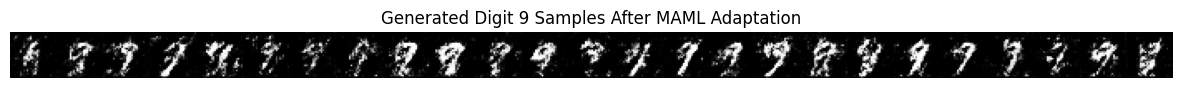

In [ ]:
from copy import deepcopy
# -----------------------------
# === Run MAML-GAN ===
# -----------------------------
if __name__ == '__main__':
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5])
    ])

    dataset = MNIST(root='./data', train=True, transform=transform, download=True)

    # Create tasks: each task has samples from one digit class (0 to 8)
    tasks = []
    for digit in range(9):  # Digits 0 to 8
        indices = [i for i, (_, label) in enumerate(dataset) if label == digit]
        subset = Subset(dataset, indices[:2000])  # Use 200 samples per task
        loader = DataLoader(subset, batch_size=32, shuffle=True)
        tasks.append(loader)

    # Create separate loader for digit 9
    indices_9 = [i for i, (_, label) in enumerate(dataset) if label == 9]
    subset_9 = Subset(dataset, indices_9[:10])  # Few-shot digit 9
    loader_9 = DataLoader(subset_9, batch_size=32, shuffle=True)

    # Initialize model and train
    gan = MAML_GAN()
    gan.outer_loop(tasks, inner_steps=1, meta_steps=200)

    # Adapt to digit 9
    gan.adapt_to_digit_9(loader_9, steps=200)

    # Generate samples
    samples = gan.generate(25)

    # Plot generated images
    samples = [img.squeeze(0) for img in samples]
    grid = torch.cat(samples, dim=1)
    plt.figure(figsize=(15, 2))
    plt.imshow(grid.numpy(), cmap='gray')
    plt.title("Generated Digit 9 Samples After MAML Adaptation")
    plt.axis('off')
    plt.show()

In [ ]:
# ✅ Install dependencies
!pip install torch torchvision matplotlib tqdm pytorch-fid torchmetrics --quiet

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader, Subset
import torchvision.utils as vutils
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import random, os
from copy import deepcopy

# Metrics
from torchmetrics.image.fid import FrechetInceptionDistance
from torchmetrics.image.inception import InceptionScore
from torchmetrics.image.kid import KernelInceptionDistance

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# -------------------------------
# Generator (DCGAN style CNN)
# -------------------------------
class Generator(nn.Module):
    def __init__(self, z_dim=100, img_channels=1):
        super().__init__()
        self.net = nn.Sequential(
            nn.ConvTranspose2d(z_dim, 128, 7, 1, 0, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, img_channels, 4, 2, 1, bias=False),
            nn.Tanh()
        )
    def forward(self, z):
        return self.net(z)

# -------------------------------
# Discriminator (DCGAN style CNN)
# -------------------------------
class Discriminator(nn.Module):
    def __init__(self, img_channels=1):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(img_channels, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 1, 7, 1, 0, bias=False),
            nn.Sigmoid()
        )
    def forward(self, x):
        return self.net(x).view(-1)

# -------------------------------
# Load MNIST
# -------------------------------
transform = transforms.Compose([
    transforms.Resize(28),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = MNIST(root="./data", train=True, download=True, transform=transform)
test_dataset = MNIST(root="./data", train=False, download=True, transform=transform)

# Split digits
def get_digit_indices(dataset, digit, max_samples=None):
    idx = [i for i, (_, y) in enumerate(dataset) if y == digit]
    if max_samples:
        idx = idx[:max_samples]
    return idx

# -------------------------------
# Training Parameters
# -------------------------------
z_dim = 100
inner_steps = 5
inner_lr = 0.1
outer_lr = 0.1
meta_epochs = 50
support_size_train = 500
support_size_test = 10

# Meta models
metaG = Generator(z_dim).to(device)
metaD = Discriminator().to(device)
meta_optimizer_G = optim.Adam(metaG.parameters(), lr=outer_lr, betas=(0.5, 0.999))
meta_optimizer_D = optim.Adam(metaD.parameters(), lr=outer_lr, betas=(0.5, 0.999))
loss_fn = nn.BCELoss()

# -------------------------------
# Meta-training on digits 0–8
# -------------------------------
print("\nStarting Meta-Training on digits 0–8...\n")
for epoch in range(meta_epochs):
    g_meta_loss, d_meta_loss = 0, 0
    for digit in range(9):  # digits 0–8
        support_idx = get_digit_indices(train_dataset, digit, support_size_train)
        query_idx = get_digit_indices(test_dataset, digit)

        support_loader = DataLoader(Subset(train_dataset, support_idx), batch_size=support_size_train)
        query_loader = DataLoader(Subset(test_dataset, query_idx), batch_size=len(query_idx))

        x_support, _ = next(iter(support_loader))
        x_query, _ = next(iter(query_loader))
        x_support, x_query = x_support.to(device), x_query.to(device)

        # Clone models
        G = deepcopy(metaG)
        D = deepcopy(metaD)
        optG = optim.Adam(G.parameters(), lr=inner_lr, betas=(0.5, 0.999))
        optD = optim.Adam(D.parameters(), lr=inner_lr, betas=(0.5, 0.999))

        # Inner loop adaptation
        for step in range(inner_steps):
            z = torch.randn(support_size_train, z_dim, 1, 1).to(device)
            fake = G(z)
            real = x_support

            # Train D
            real_labels = torch.ones(real.size(0), device=device)
            fake_labels = torch.zeros(fake.size(0), device=device)
            d_real = D(real)
            d_fake = D(fake.detach())
            d_loss = loss_fn(d_real, real_labels) + loss_fn(d_fake, fake_labels)

            optD.zero_grad()
            d_loss.backward()
            optD.step()

            # Train G
            z = torch.randn(support_size_train, z_dim, 1, 1).to(device)
            fake = G(z)
            g_fake = D(fake)
            g_loss = loss_fn(g_fake, torch.ones_like(g_fake))

            optG.zero_grad()
            g_loss.backward()
            optG.step()

            print(f"Epoch {epoch+1} | Digit {digit} | Step {step+1}/{inner_steps} "
                  f"| D_loss: {d_loss.item():.4f} | G_loss: {g_loss.item():.4f}")

        # Query set loss
        z_q = torch.randn(len(x_query), z_dim, 1, 1).to(device)
        fake_q = G(z_q)
        d_real_q = D(x_query)
        d_fake_q = D(fake_q)
        d_q_loss = loss_fn(d_real_q, torch.ones_like(d_real_q)) + \
                   loss_fn(d_fake_q, torch.zeros_like(d_fake_q))
        g_q_loss = loss_fn(D(fake_q), torch.ones_like(d_fake_q))

        d_q_loss.backward(retain_graph=True)
        g_q_loss.backward()

        d_meta_loss += d_q_loss.item()
        g_meta_loss += g_q_loss.item()

    meta_optimizer_D.step()
    meta_optimizer_G.step()
    print(f"[Epoch {epoch+1}/{meta_epochs}] D_meta_loss: {d_meta_loss/9:.4f}, G_meta_loss: {g_meta_loss/9:.4f}")

# -------------------------------
# Meta-testing on digit 9
# -------------------------------
print("\nMeta-testing on digit 9...\n")
support_idx = get_digit_indices(train_dataset, 9, support_size_test)
query_idx = get_digit_indices(test_dataset, 9)

support_loader = DataLoader(Subset(train_dataset, support_idx), batch_size=support_size_test)
query_loader = DataLoader(Subset(test_dataset, query_idx), batch_size=len(query_idx))

x_support, _ = next(iter(support_loader))
x_query, _ = next(iter(query_loader))
x_support, x_query = x_support.to(device), x_query.to(device)

# Adapt models
G = deepcopy(metaG)
D = deepcopy(metaD)
optG = optim.Adam(G.parameters(), lr=inner_lr, betas=(0.5, 0.999))
optD = optim.Adam(D.parameters(), lr=inner_lr, betas=(0.5, 0.999))

for step in range(inner_steps):
    z = torch.randn(support_size_test, z_dim, 1, 1).to(device)
    fake = G(z)
    real = x_support
    d_real = D(real)
    d_fake = D(fake.detach())
    d_loss = loss_fn(d_real, torch.ones_like(d_real)) + loss_fn(d_fake, torch.zeros_like(d_fake))

    optD.zero_grad()
    d_loss.backward()
    optD.step()

    fake = G(z)
    g_loss = loss_fn(D(fake), torch.ones_like(D(fake)))
    optG.zero_grad()
    g_loss.backward()
    optG.step()

    print(f"Adapt Step {step+1}/{inner_steps} | D_loss: {d_loss.item():.4f} | G_loss: {g_loss.item():.4f}")

# Generate samples
G.eval()
z = torch.randn(10, z_dim, 1, 1).to(device)
samples = G(z).cpu().detach()
grid = vutils.make_grid(samples, nrow=10, normalize=True)
plt.figure(figsize=(15,3))
plt.imshow(np.transpose(grid, (1,2,0)))
plt.axis("off")
plt.title("Generated Digit 9s after MAML Adaptation")
plt.show()

# -------------------------------
# Evaluation Metrics
# -------------------------------
fid = FrechetInceptionDistance(feature=64).to(device)
kid = KernelInceptionDistance(subset_size=50).to(device)
is_metric = InceptionScore().to(device)

# Compare fake vs real (digit 9 test set)
fid.update(samples.to(device), real=False)
fid.update(x_query.to(device), real=True)
print("FID:", fid.compute().item())

kid.update(samples.to(device), real=False)
kid.update(x_query.to(device), real=True)
print("KID:", kid.compute()[0].item())

is_metric.update(samples.to(device))
print("Inception Score:", is_metric.compute()[0].item())


Using device: cuda

Starting Meta-Training on digits 0–8...

Epoch 1 | Digit 0 | Step 1/5 | D_loss: 1.6508 | G_loss: 42.1769
Epoch 1 | Digit 0 | Step 2/5 | D_loss: 20.8062 | G_loss: 100.0000
Epoch 1 | Digit 0 | Step 3/5 | D_loss: 0.0000 | G_loss: 100.0000
Epoch 1 | Digit 0 | Step 4/5 | D_loss: 0.0000 | G_loss: 100.0000
Epoch 1 | Digit 0 | Step 5/5 | D_loss: 0.0000 | G_loss: 100.0000
Epoch 1 | Digit 1 | Step 1/5 | D_loss: 1.6576 | G_loss: 31.9836
Epoch 1 | Digit 1 | Step 2/5 | D_loss: 0.4781 | G_loss: 100.0000
Epoch 1 | Digit 1 | Step 3/5 | D_loss: 5.6379 | G_loss: 0.0000
Epoch 1 | Digit 1 | Step 4/5 | D_loss: 100.0000 | G_loss: 0.0000
Epoch 1 | Digit 1 | Step 5/5 | D_loss: 100.0000 | G_loss: 0.0000
Epoch 1 | Digit 2 | Step 1/5 | D_loss: 1.5945 | G_loss: 43.5181
Epoch 1 | Digit 2 | Step 2/5 | D_loss: 20.3614 | G_loss: 0.0000
Epoch 1 | Digit 2 | Step 3/5 | D_loss: 100.0000 | G_loss: 0.0000
Epoch 1 | Digit 2 | Step 4/5 | D_loss: 100.0000 | G_loss: 0.0000
Epoch 1 | Digit 2 | Step 5/5 | D_l